In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import matplotlib.pyplot as plt

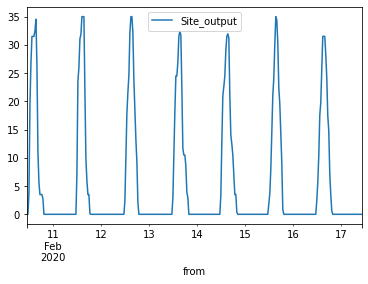

In [22]:
# Import journey and price data

prot_journeys = pickle.load(open('Data/prototype_week','rb'))
test_journeys = pickle.load(open('Data/test_week','rb'))
electricity_price = pickle.load(open('Data/price_data','rb'))
BAU_profile = pickle.load(open('Data/BAU_profile','rb'))

BAU_profile['Site_output'] = BAU_profile[gv.Power_output.values()].sum(axis=1)
BAU_profile['Electricity_costs'] = BAU_profile['Site_output'] * BAU_profile['unit_rate_excl_vat']
# Plot BAU
plot = BAU_profile.plot(x='from', y='Site_output', kind='line')
fig = plot.get_figure()
fig.savefig('Data/BAU_profile_output.png')

In [3]:
BAU_profile.head(10)

,date,from,to,unit_rate_excl_vat,Output_0,SOC_0,Output_1,SOC_1,Output_2,SOC_2,...,Output_6,SOC_6,Output_7,SOC_7,Output_8,SOC_8,Output_9,SOC_9,Site_output,Electricity_costs
0,2020/02/10,2020-02-10 11:00:00,2020-02-10 11:30:00,12.26,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,0.000000,48.932328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,0.000000,0.000000
1,2020/02/10,2020-02-10 11:30:00,2020-02-10 12:00:00,12.02,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,0.000000,48.932328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,0.000000,0.000000
2,2020/02/10,2020-02-10 12:00:00,2020-02-10 12:30:00,11.60,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,2.030000,50.962328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,3.818889,44.299111
3,2020/02/10,2020-02-10 12:30:00,2020-02-10 13:00:00,11.36,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,3.500000,54.462328,2.195278,50.989965,3.3075,50.618369,3.418333,52.729523,19.421111,220.623822
4,2020/02/10,2020-02-10 13:00:00,2020-02-10 13:30:00,8.96,0.789444,48.371947,1.9075,51.558365,3.111111,52.538839,...,3.500000,57.962328,3.500000,54.489965,3.5000,54.118369,3.500000,56.229523,26.808056,240.200178
5,2020/02/10,2020-02-10 13:30:00,2020-02-10 14:00:00,8.76,3.500000,51.871947,3.5000,55.058365,3.500000,56.038839,...,3.500000,61.462328,3.500000,57.989965,3.5000,57.618369,3.500000,59.729523,31.500000,275.940000
6,2020/02/10,2020-02-10 14:00:00,2020-02-10 14:30:00,8.78,3.500000,55.371947,3.5000,58.558365,3.500000,59.538839,...,3.500000,64.962328,3.500000,61.489965,3.5000,61.118369,3.500000,63.229523,31.500000,276.570000
7,2020/02/10,2020-02-10 14:30:00,2020-02-10 15:00:00,8.76,3.500000,58.871947,3.5000,62.058365,3.500000,63.038839,...,3.500000,68.462328,3.500000,64.989965,3.5000,64.618369,3.500000,66.729523,31.500000,275.940000
8,2020/02/10,2020-02-10 15:00:00,2020-02-10 15:30:00,8.68,3.500000,62.371947,3.5000,65.558365,3.500000,66.538839,...,3.500000,71.962328,3.500000,68.489965,3.5000,68.118369,3.500000,70.229523,32.481944,281.943278
9,2020/02/10,2020-02-10 15:30:00,2020-02-10 16:00:00,8.96,3.500000,65.871947,3.5000,69.058365,3.500000,70.038839,...,3.037672,75.000000,3.500000,71.989965,3.5000,71.618369,3.500000,73.729523,34.537672,309.457543


In [52]:
day = dt.datetime(2020,2,10)

# Creates a list of the time periods
start_datetime = day + gv.CHAR_ST_DELTA
end_datetime = start_datetime + dt.timedelta(days=1)
day_profile = BAU_profile[BAU_profile['from'] < end_datetime][['from','Output_1']]
day_profile = day_profile.merge(electricity_price[['from','unit_rate_excl_vat']], on='from')

#time_periods = day_profile['from'].to_numpy()
time_periods = list(day_profile.index)

# Create a dictionary of price costs
prices = day_profile.unit_rate_excl_vat.to_dict()

# Get required charge for the day
required_charge = list(prot_journeys.loc[(day),'Required_SOC'])

In [53]:
day_profile

,from,Output_1,unit_rate_excl_vat
0,2020-02-10 11:00:00,0.000000,12.26
1,2020-02-10 11:30:00,0.000000,12.02
2,2020-02-10 12:00:00,0.000000,11.60
3,2020-02-10 12:30:00,0.000000,11.36
4,2020-02-10 13:00:00,1.907500,8.96
5,2020-02-10 13:30:00,3.500000,8.76
6,2020-02-10 14:00:00,3.500000,8.78
7,2020-02-10 14:30:00,3.500000,8.76
8,2020-02-10 15:00:00,3.500000,8.68
9,2020-02-10 15:30:00,3.500000,8.96


In [54]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Single_vehicle_scheduling",LpMinimize)

# A dictionary called 'power_vars' is created to contain the referenced Variables
power_vars = LpVariable.dicts("Power",time_periods,0,3.5)

In [55]:
power_vars

{0: Power_0,
 1: Power_1,
 2: Power_2,
 3: Power_3,
 4: Power_4,
 5: Power_5,
 6: Power_6,
 7: Power_7,
 8: Power_8,
 9: Power_9,
 10: Power_10,
 11: Power_11,
 12: Power_12,
 13: Power_13,
 14: Power_14,
 15: Power_15,
 16: Power_16,
 17: Power_17,
 18: Power_18,
 19: Power_19,
 20: Power_20,
 21: Power_21,
 22: Power_22,
 23: Power_23,
 24: Power_24,
 25: Power_25,
 26: Power_26,
 27: Power_27,
 28: Power_28,
 29: Power_29,
 30: Power_30,
 31: Power_31,
 32: Power_32,
 33: Power_33,
 34: Power_34,
 35: Power_35,
 36: Power_36,
 37: Power_37,
 38: Power_38,
 39: Power_39,
 40: Power_40,
 41: Power_41,
 42: Power_42,
 43: Power_43,
 44: Power_44,
 45: Power_45,
 46: Power_46,
 47: Power_47}

In [ ]:
# The objective function is added to 'prob' first
prob += lpSum([prices[i]*power_vars[i] for i in time_periods]), "Total Charging costs"

# The constraints are added to 'prob'
prob += lpSum([power_vars[i] for i in time_periods]) == required_charge, "Required SOC"



In [ ]:
prob

In [ ]:
# The problem data is written to an .lp file
prob.writeLP("Models/single_vehicle.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Each of the variables is printed with it's resolved optimum value
varsdict = {}
for v in prob.variables():
    print(v.name, "=", v.varValue)

for i in range(len(prob.variables())): #FIXME add to previous loop
    #print(i,power_vars[i],power_vars[i].value())
    day_profile.loc[i,'Opt_output'] = power_vars[i].value()

# The optimised objective function value is printed to the screen
print("Total Cost of Electrivity = ", value(prob.objective))

In [ ]:
fig, axs = plt.subplots(2)
x = day_profile['from'].dt.strftime('%H')
y = day_profile['Opt_output']
prices = day_profile['unit_rate_excl_vat']
axs[0].plot(x, y, label='Optimisation output')

axs[0].plot(x, day_profile['Output_1'], label='BAU output')
axs[1].plot(x, day_profile['unit_rate_excl_vat'], label = 'Electricity price')
ax.plot(x, day_profile['Output_1'])
axs[0].legend()
axs[1].legend()
fig.show()
fig.savefig('Data/singe_veh.jpg')

In [ ]:
day_profile

In [7]:
all_journeys = pickle.load(open('Data/all_journeys','rb'))
all_journeys.head(20)

Route_ID Branch_ID Start_Time_of_Route  \
date       Vehicle_ID                                          
2019-01-01 0           2135563       513            07:30:00   
           1           2135564       513            07:30:00   
           2           2135565       513            07:30:00   
           3           2135566       513            07:30:00   
           4           2135567       513            07:44:59   
           5           2135568       513            07:44:59   
           6           2135569       513            07:44:59   
           7           2135570       513            07:44:59   
           8           2135572       513            08:00:00   
           9           2135574       513            08:00:00   
2019-01-02 0           2050385       513            05:15:00   
           1           2050387       513            05:15:00   
           2           2050389       513            05:15:00   
           3           2050388       513            05:17:59   
           4           2050391       513            05:17:59   
           5           2050390       513            05:22:00   
           6           2050392       513            05:29:59   
           7           2050386       513            05:31:00   
           8           2050406       513            05:32:00   
           9           2050413       513            05:32:00   

                      End_Time_of_Route Planned_total_Mileage Required_SOC  
date       Vehicle_ID                                                       
2019-01-01 0                   13:54:59                38.077      14.3138  
           1                   14:09:00                60.836      25.0431  
           2                   15:30:00                59.029       24.219  
           3                   12:35:00                67.061      26.9817  
           4                   14:01:00                46.394        18.98  
           5                   15:28:00                44.098      18.1613  
           6                   15:18:00                38.986       15.968  
           7                   15:20:00                34.787      12.6162  
           8                   14:27:00                43.181      16.7944  
           9                   14:06:59                34.532      13.1311  
2019-01-02 0                   12:55:00                45.267      16.6549  
           1                   14:05:00                52.342      19.2534  
           2                   13:25:00                48.808      19.3777  
           3                   13:31:59                  44.9      16.4223  
           4                   13:49:00                46.601      18.8137  
           5                   13:53:59                53.419      22.3008  
           6                   12:39:00                39.534      16.5871  
           7                   12:58:59                45.221      18.2663  
           8                   14:12:00                42.616       16.607  
           9                   12:53:00                45.408      17.9637

In [29]:
day = gv.PROTOTYPE_DAYS[0]
delta = gv.TIME_RANGE
delta

datetime.timedelta(days=8)

In [30]:
week = all_journeys[(all_journeys.index.get_level_values('date').date >= day) 
    & (all_journeys.index.get_level_values('date').date < day + delta)]

In [31]:
week.head()

,,Route_ID,Branch_ID,Start_Time_of_Route,End_Time_of_Route,Planned_total_Mileage,Required_SOC
date,Vehicle_ID,,,,,,


In [25]:
all_journeys.index.get_level_values('date').date 

array([datetime.date(2019, 1, 1), datetime.date(2019, 1, 1),
       datetime.date(2019, 1, 1), ..., datetime.date(2019, 12, 31),
       datetime.date(2019, 12, 31), datetime.date(2019, 12, 31)],
      dtype=object)

In [28]:
all_journeys.index.get_level_values('date').date >= day

array([False, False, False, ..., False, False, False])